### Script to Compute Mann Kendall trends written by Herbert. O. Misiani and Modified by Samuel Ekwacu

### Computing persistent hot spell events trends over East Africa

In [1]:
## libraries to install for first time 
#pip install regionmask
# pip install geopandas
#pip install descartes

In [2]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.path as mplPath
## for plotting a polygon
from shapely.geometry.polygon import Polygon
import geopandas as gpd

In [3]:
import shapefile as shp
import regionmask
from descartes import PolygonPatch
import matplotlib.path as mplPath

In [9]:
#uploaded.keys()
home_dir = 'F:/Folder_2022/Research/' ## read in the data
data_dir = 'Hotspells_spatial/'
plot_dir = 'python_plots/trend_plots/'
Data = xr.open_dataset(home_dir + data_dir + 'EA_hotspells-tmax_1971-2021_12.nc')  ##input file                          
#Data = xr.open_dataset(home_dir + data_dir + 'tmax2_anomaly_1961.nc')
#Data
Data=Data['hsp'].groupby('time.year').mean('time')    ## Group data into yearly means
#Data

In [10]:
dat_samp = Data.sel(lon=slice(27.5, 42.5), lat=slice(-12, 5))  ## Slice to EA
#dat_samp = Data.sel(lon=slice(-28, 50), lat=slice(-38, 38))  ## Slice to Africa
slope_val = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
p_value = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
#output = []
for i in np.arange(len(dat_samp.lat.values)):
    for j in np.arange(len(dat_samp.lon.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [11]:
## Define data as Xarray dataset and save as netcdf
output1=xr.DataArray(slope_val, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="slope.", units="hsp year-1"),)
data1 = output1.rename("trend")

output2=xr.DataArray(p_value, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")

## Save Data as netcdf
#data1.to_netcdf('EA_hotspells-tmax_1971-2021_12_trend.nc', mode='w')
#data2.to_netcdf('EA_hotspells-tmax_1971-2021_12.nc', mode='w')

In [12]:
## read the Shapefile of the Area of interest for use in masking over the required region
sf = gpd.read_file('F://Folder_2022//Research//EA_Shp//East_Africa-Disolved.shp')  ## Used in Masking
sf2 = shp.Reader('F://Folder_2022//Research//EA_Shp//EA.shp')       ## Used in plotting

#sf = gpd.read_file('F://Folder_2022//Research//Africa_Research//shapefile//afr_g2014_2013_0.shp')  ## Used in Masking
#sf2 = shp.Reader('F://Folder_2022//Research//Africa_Research//shapefile//Africa_admin1.shp')       ## Used in plotting

## Mask the trends and p_values
trend_mask = regionmask.mask_3D_geopandas(sf, data1.lon, data1.lat, lon_name='lon', lat_name='lat')
pval_mask = regionmask.mask_3D_geopandas(sf, data2.lon, data2.lat, lon_name='lon', lat_name='lat')

trnd = data1.where(trend_mask)         ## clip the data with the mask
pval = data2.where(pval_mask)

<ipython-input-13-a4222d7e6092>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hatch = ax.pcolor(dat_samp.lon, dat_samp.lat, sig_reg.data[:,:,0], cmap=none_map,
<ipython-input-13-a4222d7e6092>:29: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)


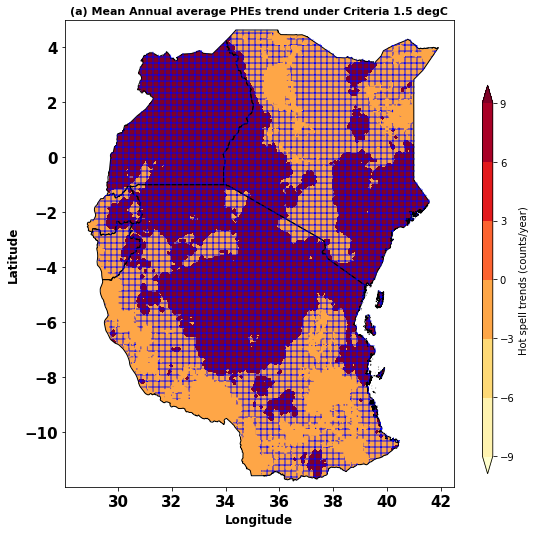

In [13]:

from matplotlib.colors import ListedColormap
none_map = ListedColormap(['none'])
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 9))

## Change this to the threshold you need.
cond = (pval >= -0.05) & (pval <= 0.05)

## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)

## Plotting the figure
for poly in sf2.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=1, fill='False', zorder=2))
    
cs = plt.contourf(dat_samp.lon, dat_samp.lat, trnd.values[:,:,0],  
               levels=np.arange(-9, 12, 3), cmap=plt.cm.YlOrRd, extend='both') #RdBu #YlOrRd  #levels=np.arange(-9, 12, 3)
## make a hatch of significance
hatch = ax.pcolor(dat_samp.lon, dat_samp.lat, sig_reg.data[:,:,0], cmap=none_map, 
                 hatch='++', edgecolor='blue', lw=0, zorder=4)
## title attributes
plt.title('(a) Mean Annual average PHEs trend under Criteria 1.5 degC',fontsize=11, fontweight='bold')
plt.xticks(size = 15, fontweight='bold')
plt.yticks(size = 15, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=12, fontweight='bold')
plt.xlabel('Longitude',fontsize=12, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
#####cax = plt.axes([0.85, 0.1, 0.018, 0.6])s
###plt.colorbar(cax=cax)
fig.colorbar(cs, ax=ax,cax = plt.axes([0.85, 0.1, 0.018, 0.6]), label='Hot spell trends (counts/year)')
# save output
plt.savefig(home_dir + plot_dir + 'EA_hotspells-tmean_1971-2021_15.jpeg')
plt.show()

### God is Greate















